# Convolutional 2D VAE

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

%cd drive/MyDrive/Colab\ Notebooks/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


Import necessary packages

In [2]:
from glob import glob
import numpy as np
from scipy.spatial.distance import pdist, squareform
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import linalg as la
from keras import regularizers
from keras import backend as K
from keras.layers import (
    Conv2D,
    Conv2DTranspose,
    Input,
    Flatten,
    Dense,
    Lambda,
    Reshape,
)


## Data Input and Pre-Processing

Define core features of the dataset.

In [3]:
dim = 2
numpart = 30
latent_dim = 50
box_size = 10


Import and reshape data.

In [4]:
dump_dir = "./dump/"
# read all position files in chosen directory
files = glob(dump_dir + "*_x.txt")
# sort files by gamma value
files = np.array(files)[np.argsort([f.split("_")[1] for f in files])]

# if different from zero, you can pick a single file with a specific gamma
choose_one_gamma = 1

if choose_one_gamma != 0:
    gamma = choose_one_gamma
    num_gammas = 1

    fname = [f for f in files if f.split("_")[1] == str(gamma)][0]
    data = np.loadtxt(fname)
    vcs = data.reshape((-1, numpart, dim)) / (box_size * np.sqrt(dim))
    labels = np.zeros(len(data))
else:
    num_gammas = files.size
    arrays = [np.loadtxt(f) for f in files]

    # combine data + reshape, and assign labels to different datasets
    data = np.vstack(arrays)
    vcs = data.reshape((-1, numpart, dim)) / (box_size * np.sqrt(dim))
    labels = np.hstack([[i] * len(a) for i, a in enumerate(arrays)])

print("Original array shape:", data.shape)
print("Reshaped array shape:", vcs.shape)


Original array shape: (10000, 60)
Reshaped array shape: (10000, 30, 2)


Sort by distance from origin

In [5]:
sort_idx = np.argsort(vcs[:, :, 0] ** 2 + vcs[:, :, 1] ** 2)
sorted_vcs = np.array(
    [sample[sort_idx[i]] for i, sample in enumerate(vcs)]
)


### Compute distance matrices

In [6]:
# metric="euclidean", force="no", checks=True are by default
dm = np.array([squareform(pdist(sample)) for sample in sorted_vcs])

print("Distance matrix shape:", dm.shape)

Distance matrix shape: (10000, 30, 30)


Split in training and test set

In [7]:
train_perc = 0.8

m = sorted_vcs.shape[0]  # total number of samples
m_training = int(m * train_perc)  # samples in the training set
m_test = m - m_training  # samples in the test set

while True:
    permutation = np.random.permutation(m)

    sorted_vcs = sorted_vcs[permutation]
    labels = labels[permutation]
    dm = dm[permutation]

    trainset_conf = sorted_vcs[:m_training]
    testset_conf = sorted_vcs[m_training:]

    trainset_mat = dm[:m_training]
    testset_mat = dm[m_training:]

    counts = [
        np.count_nonzero(labels[:m_training] == i)
        for i in range(num_gammas)
    ]

    # if each label is represented by at least half of
    # training set size / number of files
    # we're good and we can stop permutating
    if all(c > int(m_training / (2 * num_gammas)) for c in counts):
        break

print("Shape of the training set: ", trainset_conf.shape)
print("Shape of the test set: ", testset_mat.shape)


Shape of the training set:  (8000, 30, 2)
Shape of the test set:  (2000, 30, 30)


## Variational Auto Encoder (Model 1)

### Sampling class

In [8]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


### Encoder

In [9]:
encoder_inputs = keras.Input(shape=(numpart, numpart, 1))
x = Conv2D(32, 3, padding="same", activation="relu")(encoder_inputs)
# x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding="same", activation="relu")(x)
conv_shape = K.int_shape(x)  # Shape of conv to be provided to decoder
x = Flatten()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(
    encoder_inputs, [z_mean, z_log_var, z], name="encoder"
)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 30, 30, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 57600)        0           ['conv2d_1[0][0]']               
                                                                                            

### Decoder

In [10]:
decoder_input = Input(shape=(latent_dim,), name="decoder_input")
x = Dense(
    conv_shape[1] * conv_shape[2] * conv_shape[3], activation="relu"
)(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(64, 3, padding="same", activation="relu")(x)
# x = Conv2DTranspose(128, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, 3, padding="same", activation="relu")(x)
decoder_outputs = Conv2DTranspose(
    1, 3, padding="same", activation="sigmoid", name="decoder_output"
)(x)

decoder = keras.Model(decoder_input, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 57600)             2937600   
                                                                 
 reshape (Reshape)           (None, 30, 30, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 30, 30, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 30, 30, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 30, 30, 1)        289 

### VAE Class

In [11]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            size = reconstruction.shape[
                1:
            ]  # Extract dimensions excluding the first 'None' dimension
            noise = np.random.normal(0, 0.1, size=size)
            reconstruction = reconstruction + noise

            # Reshape data to match decoder output shape
            data = tf.expand_dims(data, axis=-1)

            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * (
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + reg_lambda * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Train VAE

In [12]:
reg_lambda = 0.001
vae = VAE(encoder, decoder)
vae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
)  # lower learning rate
fit = vae.fit(trainset_mat, epochs=30, batch_size=128, verbose=2)

Epoch 1/30
63/63 - 17s - loss: 0.0131 - reconstruction_loss: 0.0122 - kl_loss: 0.8681 - 17s/epoch - 264ms/step
Epoch 2/30
63/63 - 2s - loss: 0.0055 - reconstruction_loss: 0.0050 - kl_loss: 0.4383 - 2s/epoch - 30ms/step
Epoch 3/30
63/63 - 2s - loss: 0.0053 - reconstruction_loss: 0.0049 - kl_loss: 0.3859 - 2s/epoch - 26ms/step
Epoch 4/30
63/63 - 2s - loss: 0.0052 - reconstruction_loss: 0.0049 - kl_loss: 0.3334 - 2s/epoch - 25ms/step
Epoch 5/30
63/63 - 2s - loss: 0.0051 - reconstruction_loss: 0.0048 - kl_loss: 0.2825 - 2s/epoch - 24ms/step
Epoch 6/30
63/63 - 1s - loss: 0.0045 - reconstruction_loss: 0.0041 - kl_loss: 0.3772 - 1s/epoch - 21ms/step
Epoch 7/30
63/63 - 1s - loss: 0.0036 - reconstruction_loss: 0.0030 - kl_loss: 0.5612 - 1s/epoch - 21ms/step
Epoch 8/30
63/63 - 1s - loss: 0.0032 - reconstruction_loss: 0.0026 - kl_loss: 0.6042 - 1s/epoch - 21ms/step
Epoch 9/30
63/63 - 1s - loss: 0.0029 - reconstruction_loss: 0.0023 - kl_loss: 0.6244 - 1s/epoch - 21ms/step
Epoch 10/30
63/63 - 1s - 

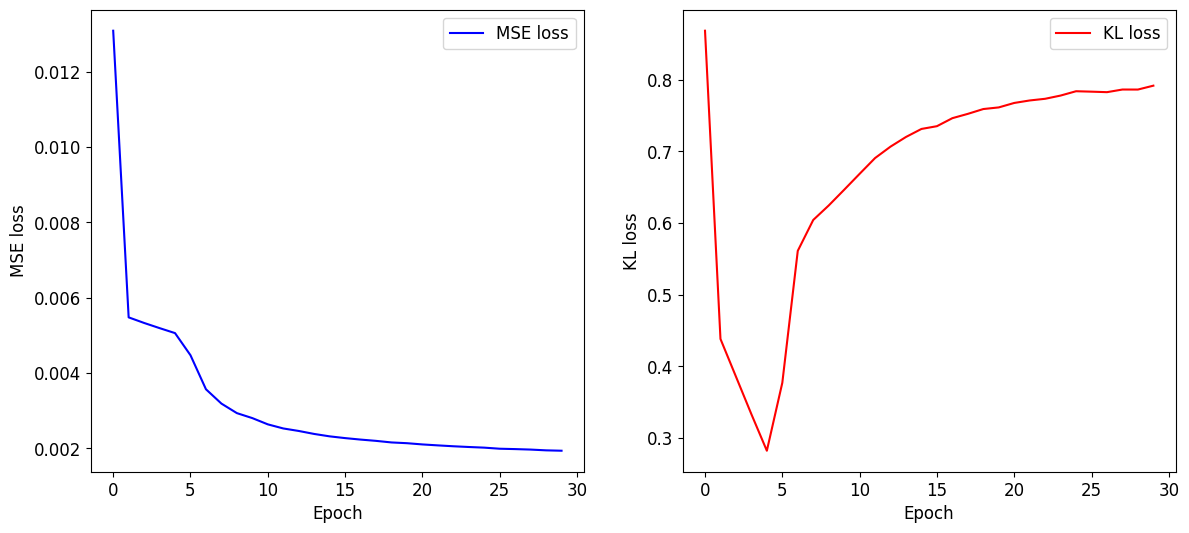

In [13]:
plt.rcParams["font.size"] = 12
fig, AX = plt.subplots(1, 2, figsize=(14, 6.0))
ax = AX[0]
ax.plot(fit.history["loss"], label="MSE loss", c="b")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE loss")
ax.legend()
ax = AX[1]
ax.plot(fit.history["kl_loss"], label="KL loss", c="r")
ax.set_xlabel("Epoch")
ax.set_ylabel("KL loss")
ax.legend()

## Evaluate performance
We'll now use the test set to explore the latent space distribution of data and the reconstruction accuracy

In [14]:
encoded_test = np.array(vae.encoder.predict(testset_mat))
encoded_train = np.array(vae.encoder.predict(trainset_mat))

print(encoded_test.shape)


250/250 [==============================] - 0s 2ms/step
(3, 2000, 50)


We can now use the data to decode

In [15]:
decoded_test = np.array(decoder.predict(encoded_test[2, :, :])).reshape(
    -1, numpart, numpart
)
decoded_train = np.array(decoder.predict(encoded_train[2, :, :])).reshape(
    -1, numpart, numpart
)
print(decoded_test.shape)

250/250 [==============================] - 0s 2ms/step
(2000, 30, 30)


### Check reconstruction

<Axes: >

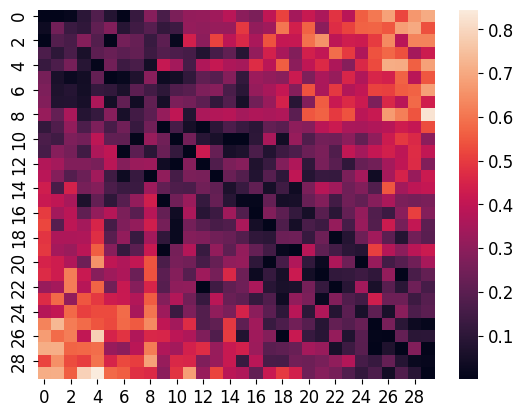

In [16]:
ind = 20
df = pd.DataFrame(decoded_test[ind])
sns.heatmap(data=df)

<Axes: >

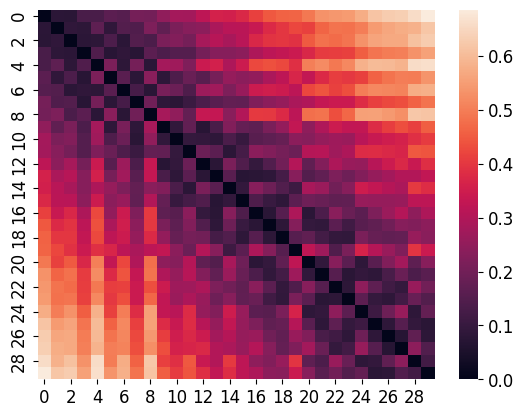

In [17]:
df2 = pd.DataFrame(testset_mat[ind])
sns.heatmap(data=df2)

## Coordinates Reconstructor (Model 2)
The reconstructor is trained on the original distance matrices and predicts the decoded matrices

In [18]:
rec_inputs = layers.Input(shape=(numpart, numpart))
x = Flatten()(rec_inputs)
x = layers.Dense(int(numpart**2 * 4 / 5), activation="relu")(x)
x = layers.Dense(int(numpart**2 * 3 / 5), activation="relu")(x)
x = layers.Dense(int(numpart**2 * 2 / 5), activation="relu")(x)
x = layers.Dense(int(numpart**2 * 1 / 5), activation="relu")(x)
x = layers.Dense(int(numpart * dim))(x)
rec_outputs = Reshape((numpart, dim))(x)
reconstruction = keras.Model(rec_inputs, rec_outputs)
reconstruction.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 30)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 900)               0         
                                                                 
 dense_1 (Dense)             (None, 720)               648720    
                                                                 
 dense_2 (Dense)             (None, 540)               389340    
                                                                 
 dense_3 (Dense)             (None, 360)               194760    
                                                                 
 dense_4 (Dense)             (None, 180)               64980     
                                                                 
 dense_5 (Dense)             (None, 60)                10860 

In [19]:
reconstruction.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.MeanSquaredError(),
)  # lower learning rate
fit = reconstruction.fit(
    trainset_mat, trainset_conf, epochs=50, batch_size=128, verbose=2
)

Epoch 1/50
63/63 - 3s - loss: 0.0258 - 3s/epoch - 50ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0050 - 264ms/epoch - 4ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0046 - 274ms/epoch - 4ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0043 - 274ms/epoch - 4ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0040 - 279ms/epoch - 4ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0037 - 287ms/epoch - 5ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0035 - 222ms/epoch - 4ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0033 - 211ms/epoch - 3ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0031 - 207ms/epoch - 3ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0030 - 200ms/epoch - 3ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0028 - 213ms/epoch - 3ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0027 - 215ms/epoch - 3ms/step
Epoch 13/50
63/63 - 0s - loss: 0.0025 - 220ms/epoch - 3ms/step
Epoch 14/50
63/63 - 0s - loss: 0.0024 - 205ms/epoch - 3ms/step
Epoch 15/50
63/63 - 0s - loss: 0.0023 - 207ms/epoch - 3ms/step
Epoch 16/50
63/63 - 0s - loss: 0.0022 - 207ms/epoch - 3ms/step
Epo

In [20]:
rec_test = np.array(reconstruction.predict(testset_mat))
rec_test_dec = np.array(reconstruction.predict(decoded_test))

63/63 [==============================] - 0s 2ms/step


### Evaluate performance
Original data is in blue, reconstructed original configurations in gold

(-0.15, 1.15)

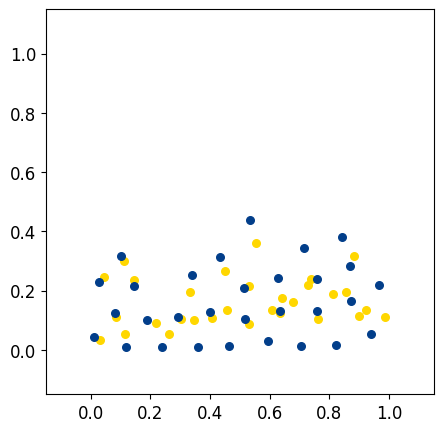

In [21]:
ind = 20
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    rec_test[ind, :, 0] * l, rec_test[ind, :, 1] * l, s=30, c="gold"
)
ax.scatter(
    testset_conf[ind, :, 0] * l,
    testset_conf[ind, :, 1] * l,
    s=30,
    c="#023e8a",
)
ax.set_xlim(-0.15, 1.15)
ax.set_ylim(-0.15, 1.15)

Original data is in 

(-0.15, 1.15)

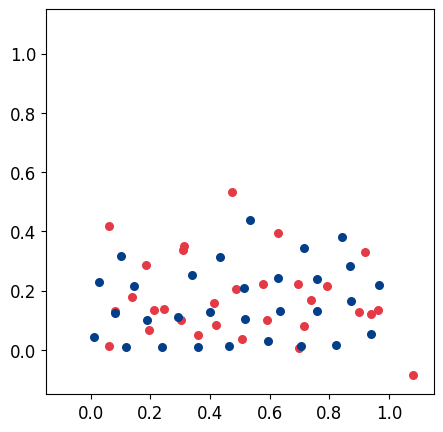

In [22]:
ind = 20
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    rec_test_dec[ind, :, 0] * l,
    rec_test_dec[ind, :, 1] * l,
    s=30,
    c="#e63946",
)
ax.scatter(
    testset_conf[ind, :, 0] * l,
    testset_conf[ind, :, 1] * l,
    s=30,
    c="#023e8a",
)
ax.set_xlim(-0.15, 1.15)
ax.set_ylim(-0.15, 1.15)

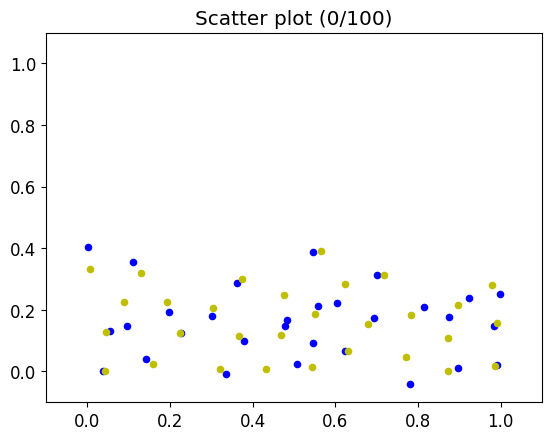

In [23]:
from matplotlib.animation import FuncAnimation

# Create the figure and axis objects
fig, ax = plt.subplots()

nframes = 100


# Define the animation function
def update(ind):
    ax.clear()
    plt.scatter(
        rec_test[ind, :, 0] * l, rec_test[ind, :, 1] * l, s=20, c="b"
    )
    plt.scatter(
        testset_conf[ind, :, 0] * l,
        testset_conf[ind, :, 1] * l,
        s=20,
        c="y",
    )
    ax.set_title(f"Scatter plot ({ind}/{nframes})")
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)


# Create the animation
animation = FuncAnimation(fig, update, frames=nframes, interval=400)

# Save the animation as a GIF
animation.save("conv2dist.gif", writer="imagemagick")

## Deez Labels

In [24]:
import sklearn
from sklearn.decomposition import PCA


def label_vis(vae, data, labels):
    # prediction
    z_mean, _, _ = vae.encoder.predict(data)

    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(z_mean)
    variance_ratio = pca.explained_variance_ratio_
    print(variance_ratio)

    # plot
    plt.figure(figsize=(5, 5))
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

313/313 [==============================] - 2s 6ms/step
[0.04738011 0.04454647]


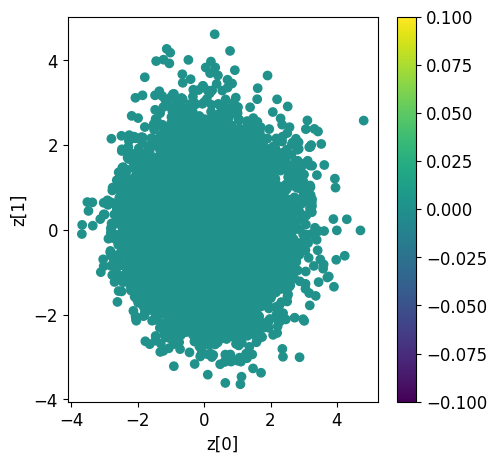

In [25]:
label_vis(vae, dm, labels)


## Energy test

In [53]:
def potential(x):
    """
    Calculate LJ + gravitational potential given a positions array.

    INPUTS
        x: array of shape (num_particles, dimension)

    NOTE: gamma is a global variable
    """

    n = len(x)
    pot = 0.0
    for i in range(n - 1):
        pot += gamma * x[i, -1]
        for j in range(i + 1, n):
            r2 = np.sum((x[i, :] - x[j, :]) ** 2)
            if r2 < 9.0:  # r_cut = 3 sigma
                sr6 = 1.0 / r2**3
                pot += 4 * (sr6**2 - sr6)
    pot += gamma * x[-1, -1]

    return pot


In [54]:
scale_factor = box_size * np.sqrt(dim)
ori_pots = [potential(sample) for sample in testset_conf * scale_factor]
rec_pots = [potential(sample) for sample in rec_test * scale_factor]

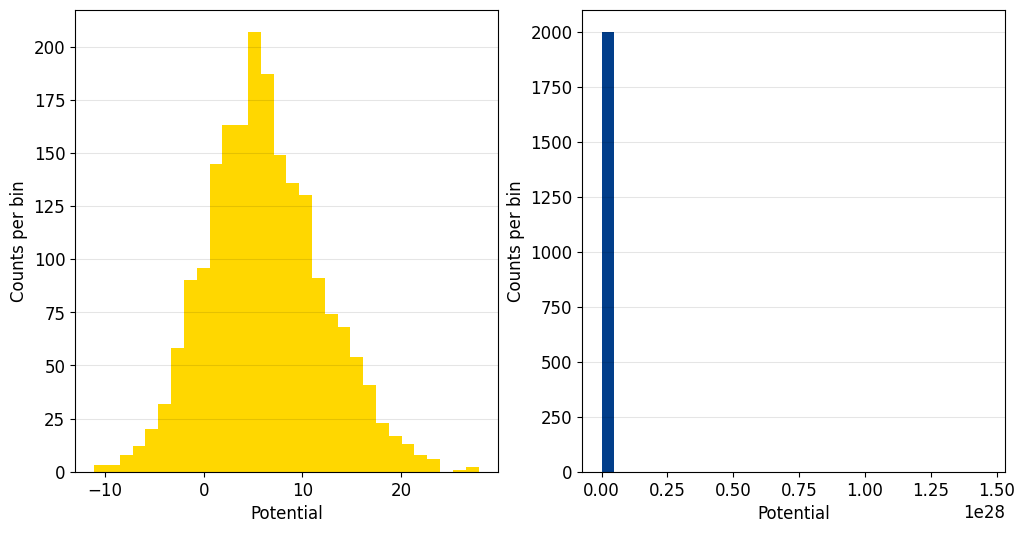

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].hist(ori_pots, bins=30, facecolor="gold")
ax[0].set_title("Original")
ax[1].hist(rec_pots, bins=30, facecolor="blue")
ax[1].set_title("Reconstruction")

for i in range(2):
    ax[i].set_xlabel("Potential")
    ax[i].set_ylabel("Counts per bin")
    ax[i].grid(axis="y", alpha=0.1, color="black")